# **GDSC Solution Challenge**
## **SDG-16 : Peace, Justice and strong Institutions**
### Building **Deep Learning Model** for checking if video given by **CCTV Cameras** consists of an **Anamoly events**
- In response to the growing need for **proactive security measures**, our project focuses on developing an **Advanced AI model** for  **Real-Time CCTV Surveillance System** designed to swiftly **detect and report criminal activities** to the **appropriate authorities**. 
- Leveraging cutting-edge technologies such as **CNNs and LSTMs**, we aim to swiftly identify critical events like **fighting, shoplifting, abuse**, and more .
- By accurately identifying the **nature of the crime**, this system aids in directing the information to the relevant agencies, thereby enhancing the efficiency of law enforcement. 
- By **reducing crime rates** and **facilitating the prompt handling of criminal incidents**, our initiative contributes to **fostering peace within communities** and **reinforces the establishment of resilient institutions**, thus advancing the objectives of **SDG16**

Orignal Idea : https://www.crcv.ucf.edu/projects/real-world/


**Team Members**:
1) Tushar Mittal (GDSC Core Team Member (IIT Mandi,India))
2) Toshan Gupta
3) Mayank Goel
4) Devansh Sehgal

In [ ]:
#<----------------------------------------------------------------------------------------------------------------------------------------------------->
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#<------------------------------------------------------------------------------------------------------------------------------------------------------->
#Deep Learning Libraries
import tensorflow as tf
from collections import deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
#<----------------------------------------------------------------------------------------------------------------------------------------------------->

# ***Dataset***
- Our model's training process hinges on the comprehensive and diverse **UCF Crime Dataset**, a meticulously curated repository of **video clips** capturing various **criminal activities**. This dataset provides a rich tapestry of real-world scenarios, allowing our AI system to learn and adapt to a wide range of anomaly events. 

- By leveraging this extensive dataset, we ensure that our model is equipped to handle diverse environmental conditions, lighting variations, and behavioral patterns commonly encountered in surveillance footage. This strategic utilization of data not only enhances the robustness of our model but also instills confidence in its ability to accurately detect anomalies in real-time CCTV video streams.

- Classes:
    1) Normal Videos (150 videos)
    
    2) Anomaly Videos (400 videos)
        - Abuse (50 videos)
        - Arrest (50 videos)
        - Arson (50 videos)
        - Assault (50 videos)
        - Burglary (100 videos)
        - Explosion (50 videos)
        - Fighting (50 videos)

DataSet Link: https://www.kaggle.com/datasets/mission-ai/crimeucfdataset

    Storing path of all anomaly videos 

In [ ]:
#<----------------------------------------------------------------------------------------------------------------------------------------------------->
#Anomaly videos data 
fld="/kaggle/input/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1"
fld1="/kaggle/input/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2"
anomalylist = []
for i in os.listdir(fld):
    l=os.listdir(os.path.join(fld,i))
    for j in l:
        k= os.path.join(os.path.join(fld,i,j))
        anomalylist.append(k)
for i in os.listdir(fld1):
    l=os.listdir(os.path.join(fld1,i))
    for j in l:
        k= os.path.join(os.path.join(fld1,i,j))
        anomalylist.append(k)
#<----------------------------------------------------------------------------------------------------------------------------------------------------->

    Storing path of all Normal Videos

In [ ]:
#<----------------------------------------------------------------------------------------------------------------------------------------------------->
#Normal Videos data
fld2="/kaggle/input/Anomaly_Dataset/Anomaly_Videos/Normal-Videos-Part-1"
normallist = []
for i in os.listdir(fld2):
    l=(os.path.join(fld2,i))
    normallist.append(l)
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)
#<----------------------------------------------------------------------------------------------------------------------------------------------------->


    Declaring the Standard values 


In [10]:
#<----------------------------------------------------------------------------------------------------------------------------------------------------->
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 50
classeslist =[anomalylist,normallist]
#<----------------------------------------------------------------------------------------------------------------------------------------------------->

# **Data-Reading**

1) **Reading Video**:
    `cv2.VideoCapture(video_path)`

2) **Skipping Few Frames**:
    `skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)`

3) **Pre-processing steps**:
    - Resizes each frame to (64,64,3)
    - Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1

4) **Return:** The frame list after apply preprocessing steps

In [11]:
#<----------------------------------------------------------------------------------------------------------------------------------------------------->
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list
#<----------------------------------------------------------------------------------------------------------------------------------------------------->

    Calling the frames extraction to show its effect of one of the subclass

In [12]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
k = frames_extraction(anomalylist[0])
print(np.shape(k))
#<--------------------------------------------------------------------------------------------------------------------------------------->

(50, 64, 64, 3)


# **Video Preprocessing and Classification: Building a Foundation for Anomaly Detection**
- As a crucial step in our workflow, preprocessing the video involves extracting individual frames and standardizing their dimensions for uniformity. By ensuring consistency in both height and length, we lay the foundation for accurate analysis and classification of video content.

- Once standardized, the frames undergo classification labeling, where each frame is assigned a specific category based on its content. This classification step serves as a preliminary assessment, enabling us to organize and categorize the video frames according to the presence or absence of anomaly events.

- By meticulously preprocessing the video data and labeling the frames, we establish a structured framework for subsequent analysis and model training. This systematic approach not only streamlines the data preparation process but also sets the stage for robust anomaly detection in CCTV videos.

In [13]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
labels1 = ["anomaly","normal"]
#<--------------------------------------------------------------------------------------------------------------------------------------->
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classeslist):
        for i in class_name:         
            frames = frames_extraction(i)
            if(len(frames)== SEQUENCE_LENGTH):
                features.append(frames)
                labels.append(labels1[class_index])
    np.asarray(features)
    np.array(labels)
    return  features,labels     
#<--------------------------------------------------------------------------------------------------------------------------------------->   

    Labeling Video Frames: Categorizing Anomaly Events for Analysis
    Anomaly:0
    Normal:1

In [14]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
features ,labels =create_dataset()
new_labels=[]
a=0
b=1
for item in labels:
    if item=='anomaly':
        new_labels.append(a)
    if item=='normal':
        new_labels.append(b)
#<--------------------------------------------------------------------------------------------------------------------------------------->

Using Keras's to_categorical method to convert labels into **one-hot-encoded vectors**

In [16]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
one_hot_encoded_labels = to_categorical(new_labels)
print(one_hot_encoded_labels)
#<--------------------------------------------------------------------------------------------------------------------------------------->

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


    Partitioning Data: Allocating 75% to Training and 25% to Testing Sets

In [18]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,test_size = 0.25,         
                                                                    shuffle = True,random_state = seed_constant)

features_test = np.array(features_test)
labels_test = np.array(labels_test)
#<--------------------------------------------------------------------------------------------------------------------------------------->
print(np.shape(labels_test))
print(np.shape(features_test))
#<--------------------------------------------------------------------------------------------------------------------------------------->

(138, 2)
(138, 50, 64, 64, 3)


# **LRCN Model: Long-term Recurrent Convolutional Network**

- In our quest to build a powerful deep learning model for anomaly detection in CCTV videos, we employ the innovative **Long-term Recurrent Convolutional Network (LRCN) architecture**. This cutting-edge approach combines the strengths of **both convolutional neural networks (CNNs) and recurrent neural networks (RNNs)**, specifically utilizing LSTM (Long Short-Term Memory) units for effective temporal modeling.

- The LRCN model begins with a convolutional network, which **extracts spatial features** from individual frames of the video. 
- These features are then fed into the recurrent neural network component, where the **LSTM units capture temporal dependencies across successive frames**. - This integration enables our model to effectively analyze both spatial and temporal aspects of the video data, thereby enhancing its ability to detect complex anomaly events.

- By leveraging the LRCN architecture, we create a sophisticated deep learning model that is capable of capturing intricate patterns and dynamics present in CCTV video streams. This approach not only enhances the accuracy of anomaly detection but also ensures robustness in handling real-world scenarios with varying complexities and durations.

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [20]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(classeslist), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model
#<--------------------------------------------------------------------------------------------------------------------------------------->

    Creating the Model Architecture

In [32]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
# Construct the required LRCN model.
LRCNn_model = create_LRCN_model()
#<--------------------------------------------------------------------------------------------------------------------------------------->
# Display the success message.
print("Model Created Successfully!")
#<--------------------------------------------------------------------------------------------------------------------------------------->

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 50, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 50, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 50, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 50, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 50, 4, 4, 32)     


    Visualize the Architecture of the Created LRCN Model

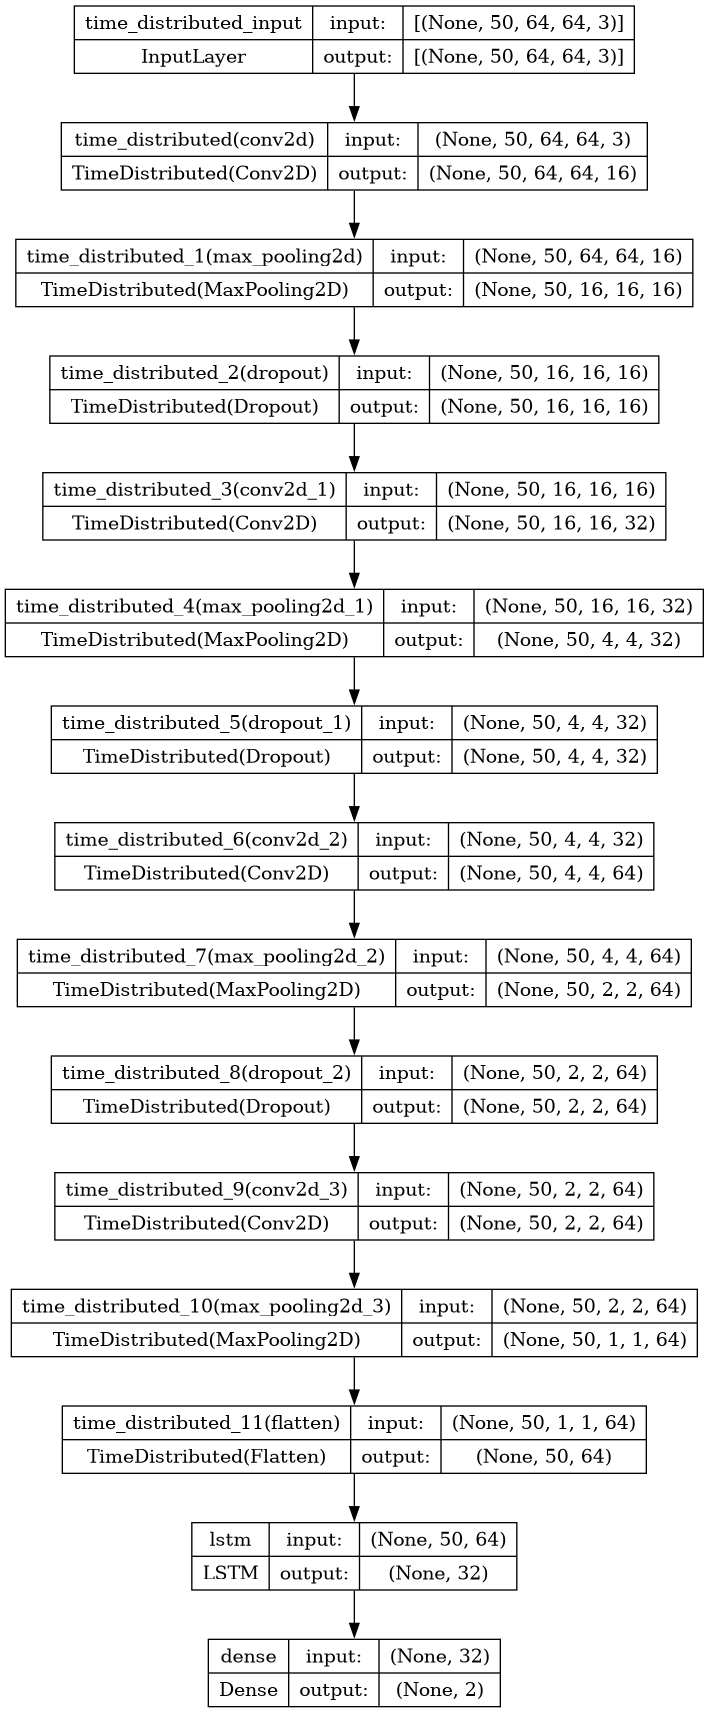

In [22]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
# Plot the structure of the contructed LRCN model.
plot_model(LRCNn_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)
#<--------------------------------------------------------------------------------------------------------------------------------------->

# **Model Training Approach**

1) **Initializing Early Stopping for Preventing Overfitting**:
    - To ensure effective training of our LRCN model while **preventing overfitting**, we employ the **Early Stopping Callback mechanism**. 
    - This strategy allows us to monitor the validation loss during training and halt the process when improvements cease, thus avoiding excessive model fitting to the training data.

2) **Compiling the Model with Essential Components**:
    - Our model is compiled using a **categorical cross-entropy loss function**, which is well-suited for multi-class classification tasks like anomaly detection. 
    - The **Adam optimizer**, known for its efficiency and adaptability, is utilized to optimize the model parameters. Furthermore, the accuracy metric is chosen to evaluate the model's performance during training.

3) **Training Process Details**:
    - The training process spans across **70 epochs**, providing ample iterations for the model to learn from the training data. 
    - A **batch size of 14** is selected to balance computational efficiency and model stability. 
    - Additionally, **20% of the training data is reserved for validation purposes**, enabling us to assess the model's generalization capabilities during training.

4) **Leveraging Early Stopping Callback**:
    - The Early Stopping Callback is integrated into the training process to monitor the validation loss continuously. 
    - When the validation loss fails to improve over a specified number of epochs (patience), the training process is halted, and the model's weights are restored to the configuration that achieved the best validation performance. 
    - This proactive measure helps prevent overfitting and ensures the generalization ability of our model.


In [33]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
# Create an Instance of Early Stopping Callback.
features_train = np.array(features_train)
labels_train = np.array(labels_train)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCNn_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCNn_model_training_history = LRCNn_model.fit(x = features_train, y = labels_train, epochs = 70,batch_size=14,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
#<--------------------------------------------------------------------------------------------------------------------------------------->

Epoch 1/70
24/24 [==============================] - 8s 150ms/step - loss: 0.6348 - accuracy: 0.7082 - val_loss: 0.5642 - val_accuracy: 0.7590
Epoch 2/70
24/24 [==============================] - 1s 46ms/step - loss: 0.6008 - accuracy: 0.7082 - val_loss: 0.5487 - val_accuracy: 0.7590
Epoch 3/70
24/24 [==============================] - 1s 45ms/step - loss: 0.6017 - accuracy: 0.7082 - val_loss: 0.5430 - val_accuracy: 0.7590
Epoch 4/70
24/24 [==============================] - 1s 46ms/step - loss: 0.5768 - accuracy: 0.7082 - val_loss: 0.5503 - val_accuracy: 0.7470
Epoch 5/70
24/24 [==============================] - 1s 45ms/step - loss: 0.5734 - accuracy: 0.7234 - val_loss: 0.5263 - val_accuracy: 0.7590
Epoch 6/70
24/24 [==============================] - 1s 46ms/step - loss: 0.5411 - accuracy: 0.7082 - val_loss: 0.4660 - val_accuracy: 0.7831
Epoch 7/70
24/24 [==============================] - 1s 45ms/step - loss: 0.4955 - accuracy: 0.7538 - val_loss: 0.4366 - val_accuracy: 0.7711
Epoch 8/70
2

    
    Assessing the Performance of the Trained Model.

In [34]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
features_test = np.array(features_test)
labels_test = np.array(labels_test)
#<--------------------------------------------------------------------------------------------------------------------------------------->
# Evaluate the trained model.
model_evaluation_history = LRCNn_model.evaluate(features_test, labels_test)
#<--------------------------------------------------------------------------------------------------------------------------------------->

5/5 [==============================] - 0s 34ms/step - loss: 0.4873 - accuracy: 0.7971


    saving the model 

In [35]:
#<--------------------------------------------------------------------------------------------------------------------------------------->
LRCNn_model.save("mod.h5")
#<--------------------------------------------------------------------------------------------------------------------------------------->

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
